# **Reference**
**아래 코드는 https://github.com/lukemelas/Automatic-Image-Colorization/ 의 코드를 바탕으로하여 만든 코드입니다.**

# **0. Basics**
해당 코드를 돌리기 위한 기본적인 사항들 입니다.

(Ex : import module, 구글드라이브 마운트, 변수선언, 유용한 함수선언 등)

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time, sys
# Too ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

num_class = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_losses = 1e+6 # lowest validation loss
current_epoch = 0  # start from epoch 0 or last checkpoint epoch
train_loss_list = [] # training loss list
val_loss_list = [] # validation loss list
if torch.cuda.is_available():
  print("현재 사용중인 GPU : {}".format(torch.cuda.get_device_name(0)))
else:
  print("현재 GPU를 사용하고 있지 않습니다.")

현재 사용중인 GPU : GeForce GTX 1060 6GB


In [15]:
# 구글 드라이브 마운트 - 이하 코드는 구글 코랩에서 작업하기 위한 코드들입니다. 로컬에서 작업하실거면 무시하셔도 됩니다.
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project")
sys.path.append('/content/drive/My Drive/Colab Notebooks/딥러닝의 기초/Project')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **1. Loading dataset**

## 1.1 Custom Dataset

지정된 경로에 있는 모든 이미지를 갖고있는 객체를 만드는 클래스입니다. 예를들어



```
train_imagefolder = GrayscaleImageFolder('./dataset/train/', train_transforms)
```

위 코드는 './dataset/train/(아무폴더)'디렉토리에 있는 모든 이미지를 모은 객체를 생성합니다.

이때 우리가 불러오고자하는 이미지들은 반드시 train폴더가 아닌 train폴더안의 (아무폴더)에 들어있어야 합니다.


한편 transforms는 Data augmentation을 적용하기 위한 argument입니다. 


```
train_imagefolder[idx]
```
위 코드는 해당 객체의 idx번째 이미지로부터 (Grayscale된 이미지), (ab 이미지), (원본 이미지)를 반환합니다.



In [5]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, label = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
        img = self.transform(img)
    img = np.asarray(img)
    img_gray = rgb2gray(img)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    if self.target_transform is not None:
        target = self.target_transform(target)
    
    return img_gray, label

## 1.2 Data Augmentation & Loading

Data Augmentation(데이터 증강)을 적용하고 데이터를 로드하는 코드입니다. 
Data Augmentation은 transform_augmentation을 수정하여 바꿀 수 있습니다. 예를들어



```
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip()])
```
위 코드는

(1) 원본 이미지에서 256 * 256 만큼 Randomcrop하고

(2) 일정확률로 위 아래를 뒤집기

하는 역할을 합니다.

Pytorch에서 기본적으로 지원하는 Augmentation 기법들은 https://pytorch.org/docs/stable/torchvision/transforms.html 에서 확인할 수 있습니다.

In [6]:
# Training
print('Loading Training data...', end=' ')
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((256,256), ),
    transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('../../dataset/flower102/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=4, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = transforms.Compose([
    transforms.Resize((256,256)),])
val_imagefolder = GrayscaleImageFolder('../../dataset/flower102/val', val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=4, shuffle=False)
print("Done!")
print("Training data size : {}".format(len(val_imagefolder)))


Loading Training data... Done!
Training data size : 6552
Loading Validation data... Done!
Training data size : 818


## 1.3 Dataset Test

Dataset이 성공적으로 만들어졌는지 확인하는 코드입니다.
Grayscale 이미지와 Label이 나와야 합니다.

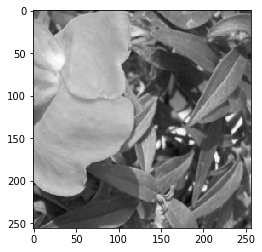

Label : 5


In [7]:
import random

i = random.randint(0, len(train_imagefolder))
temp_gray, temp_label = train_imagefolder[i]

plt.imshow(temp_gray.squeeze(), cmap='gray')
plt.rcParams["figure.figsize"] = (10,5)

plt.show()

print('Label : {}'.format(temp_label))

# **2. Construct the Model**

학습에 쓸 모델에 해당하는 코드입니다.

In [8]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()        
        class Encoder(nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                # Build ResNet and change first conv layer to accept single-channel input
                self.resnet = models.resnet50(pretrained=True)
                self.resnet.conv1.weight = nn.Parameter(self.resnet.conv1.weight.sum(dim=1).unsqueeze(1).data)
                self.fc = nn.Linear(1000, 102)

            def forward(self, input_image):
                # Pass input through ResNet-gray to extract features
                output = self.resnet(input_image)
                output = self.fc(output)
                return output

        self.encoder = Encoder()

    def forward(self, input):
        encode = self.encoder(input)
        #output = self.decoder(encode)

        return encode

model = ColorizationNet()
model = model.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))
print(model.encoder)

Number of parameters: 25652862
Encoder(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

)


# **3. Save / Load the model**

## 3.1 Save the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일로 저장합니다.

In [9]:
def save(model, epoch, best_losses):
    print('Saving...', end=' ')
    state = {
        'state_dict': model.state_dict(),
        'epoch': epoch,
        'best_losses' : best_losses,
        }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/encoder/resnet50_encoder_ckpt.pth')
    print("Done!")

In [11]:
save(model.encoder, current_epoch, best_losses)

Saving... Done!


## 3.2 Load the model
./checkpoint/ 디렉토리에 현재 모델을 'ckpt.pth'파일을 불러옵니다.

In [10]:
def load(model):
    global current_epoch, best_losses
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/encoder/resnet50_encoder_ckpt.pth')
    model.load_state_dict(checkpoint['state_dict'])
    current_epoch = checkpoint['epoch']
    best_losses = checkpoint['best_losses']
    model.eval()
    print("Done!")
    print("Current epoch : {}, Current best_losses {}".format(current_epoch, best_losses))


In [12]:
load(model)

Loading... Done!
Current epoch : 8, Current best_losses 3.7339044211837655


# **4. Train the Model**

## 4.1 Set hyperparameters, optimizer, loss, etc.

하이퍼파라미터, Loss Function, 옵티마이저, epoch 등을 결정합니다.

In [13]:
epoch_num = 3 # 반복할 epoch 수
criterion = nn.CrossEntropyLoss() # Loss 함수 
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-5, nesterov=True) # 옵티마이저
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=32, shuffle=True) # 트레이닝 배치사이즈
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=32, shuffle=False) # Validation 배치사이즈

## 4.2 Train and validate the model

모델을 트레이닝하여 매 에폭마다 Validation Loss를 측정합니다.

만약 Validation Loss가 최저값으로 갱신되면 모델을 저장합니다.

In [14]:
# training function
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    
    total = 0
    correct = 0
    
    end = time.time()
    for i, (input_gray, input_label) in enumerate(train_loader):

        # Use GPU if available
        input_gray = input_gray.to(device)
        input_label = input_label.to(device)
        criterion = criterion.to(device)

        # Record time to load data (above)
        data_time.update(time.time() - end)

        # Run forward pass
        output = model(input_gray) 
        loss = criterion(output, input_label) 
        losses.update(loss.item(), input_gray.size(0))
        
        predicted = torch.argmax(output, dim=1)
        
        for j in range(len(output)):
            if predicted[j] == input_label[j]:
                correct += 1
            total += 1
        
        
        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

        # Print model accuracy -- in the code below, val refers to value, not validation
        print('\rEpoch: [{0}]\t Batch:[{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.6f} ({loss.avg:.6f})\t'
            .format(
            epoch, i+1, len(train_loader), batch_time=batch_time,
            data_time=data_time, loss=losses), end='') 
        
        del input_gray
        del input_label
    print()
    print('Training Accuracy : {:3f} %, Loss : {:6f}'.format(100 * correct/total, losses.avg))
    # record the loss
    train_loss_list.append(losses.avg)

In [15]:
# validate function
def validate(train_loader, model, criterion, optimizer, epoch):
    global best_losses
    model.eval()
    with torch.no_grad():
    
        # Prepare value counters and timers
        batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

        total = 0
        correct = 0

        end = time.time()
        for i, (input_gray, input_label) in enumerate(val_loader):

            # Use GPU if available
            input_gray = input_gray.to(device)
            input_label = input_label.to(device)
            criterion = criterion.to(device)

            # Record time to load data (above)
            data_time.update(time.time() - end)

            # Run forward pass
            output = model(input_gray)
            output = torch.softmax(output, dim=1)
            loss = criterion(output, input_label) 
            losses.update(loss.item(), input_gray.size(0))

            predicted = torch.argmax(output, dim=1)

            for j in range(len(output)):
                if predicted[j] == input_label[j]:
                    correct += 1
                total += 1

            # Record time to do forward and backward passes
            batch_time.update(time.time() - end)
            end = time.time()

            del input_gray
            del input_label

            # Print model accuracy -- in the code below, val refers to value, not validation
            print('\rEpoch: [{0}]\t Batch:[{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.6f} ({loss.avg:.6f})\t'
                .format(
                epoch, i+1, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses), end='') 
        print()
        print('Validation Accuracy : {:.3f} %, Loss : {:.6f}'.format(100 * correct/total, losses.avg))
        if losses.avg < best_losses:
            best_losses = losses.avg
            save(model, current_epoch, best_losses)
        # record the loss
        val_loss_list.append(losses.avg)

In [16]:
# Train model
for epoch in range(current_epoch, current_epoch + epoch_num):
    # Train for one epoch, then validate
    train(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, optimizer ,epoch)
    current_epoch += 1
    print('=================================================================================================')
    
print('Done')

Epoch: [8]	 Batch:[205/205]	Time 0.431 (0.488)	Data 0.225 (0.229)	Loss 0.326159 (0.217199)	
Training Accuracy : 94.520757 %, Loss : 0.217199
Epoch: [8]	 Batch:[26/26]	Time 0.190 (0.328)	Data 0.102 (0.176)	Loss 3.777181 (3.738529)	
Validation Accuracy : 93.521 %, Loss : 3.738529
Epoch: [9]	 Batch:[16/205]	Time 0.495 (0.478)	Data 0.229 (0.223)	Loss 0.084812 (0.215861)	

KeyboardInterrupt: 

In [17]:
validate(val_loader, model, criterion, optimizer, current_epoch)

Epoch: [0]	 Batch:[26/26]	Time 0.300 (0.516)	Data 0.205 (0.326)	Loss 4.630255 (4.625968)	
Validation Accuracy : 0.122 %, Loss : 4.625968
Saving... Done!


# **5. Show the results**

## 5.1 Test an image

하나의 Validation 이미지에 대한 test 결과를 보여줍니다.

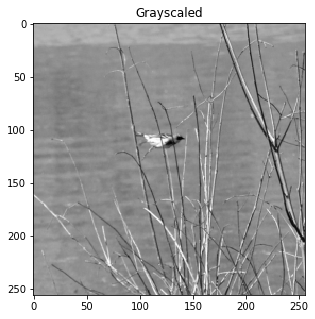

Label : 170, Predicted : 125


In [17]:
with torch.no_grad():
    i = random.randint(0, len(val_imagefolder))
    temp_gray, temp_label = val_imagefolder[i]
    temp_gray = temp_gray.unsqueeze(0).float()
    temp_gray = temp_gray.to(device)
    
    predicted = model(temp_gray)
    temp_gray = temp_gray[0].cpu()
    
    plt.imshow(temp_gray[0], cmap='gray')
    plt.title('Grayscaled')

    plt.show()
    print('Label : {}, Predicted : {}'.format(temp_label, torch.argmax(predicted)))

## **5.2 Plot the losses**

Training Loss와 Validation Loss 그래프를 출력합니다.

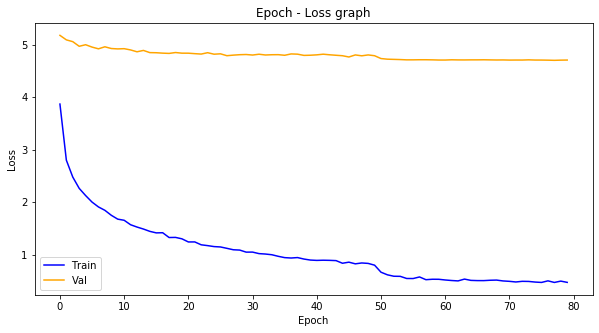

In [18]:
plt.plot(train_loss_list[:], color = 'blue')
plt.plot(val_loss_list[:], color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch - Loss graph')
plt.legend(['Train', 'Val'])

plt.show()

# **6. Others**


## 6.1 Initialize record and model

current_epoch, best_losses, model을 초기화합니다.

In [51]:
current_epoch = 0
best_losses = 100000
model = Classifier()
model.to(device)

Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [52]:
train_loss_list = []
val_loss_list = []

## 6.3 참고자료
[1] Colorful Image Colorization Richard Zhang, Phillip Isola, Alexei A. Efros 
(Submitted on 28 Mar 2016 (v1), last revised 5 Oct 2016 (this version, v5))
https://arxiv.org/abs/1603.08511

[2] Deep Colorization, Zezhou Cheng, Qingxiong Yang, Bin Sheng
(Submitted on 30 Apr 2016)
https://arxiv.org/abs/1605.00075